## Assignment 1 
Name: Navaneethakrishnan

Roll no.: DA24S008


Code blocks common for all the questions

In [1]:
from keras.datasets import fashion_mnist
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

class Activations:
    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))
    
    @staticmethod
    def sigmoid_derivative(x):
        return x * (1 - x)
    
    @staticmethod
    def relu(x):
        return np.maximum(0, x)
    
    @staticmethod
    def relu_derivative(x):
        return (x > 0).astype(float)
    
    @staticmethod
    def tanh(x):
        return np.tanh(x)
    
    @staticmethod
    def tanh_derivative(x):
        return 1 - np.tanh(x) ** 2

def softmax(x):
    exp = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp / np.sum(exp, axis=1, keepdims=True)


def onehot(y, num_class):
    one_hot = np.zeros((y.shape[0], num_class))
    one_hot[np.arange(y.shape[0]), y] = 1
    return one_hot

def cross_ent_loss(yTrue, yPred):
    return -np.sum(yTrue * np.log(yPred + 1e-8)) / yTrue.shape[0]

def accuracy_calc(y_true, y_pred):
    return np.mean(np.argmax(y_pred, axis=1) == np.argmax(y_true, axis=1))

def sqrd_error_loss(yTrue, yPred):
    return np.mean(np.square(yTrue - yPred))

(xTrain, yTrain), (xTest, yTest) = fashion_mnist.load_data()


2025-03-17 16:36:07.060057: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742209567.075286 1609663 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742209567.079675 1609663 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-17 16:36:07.097144: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Question 1 (2 Marks)
Download the fashion-MNIST dataset and plot 1 sample image for each class as shown in the grid below. Use ```from keras.datasets import fashion_mnist``` for getting the fashion mnist dataset.

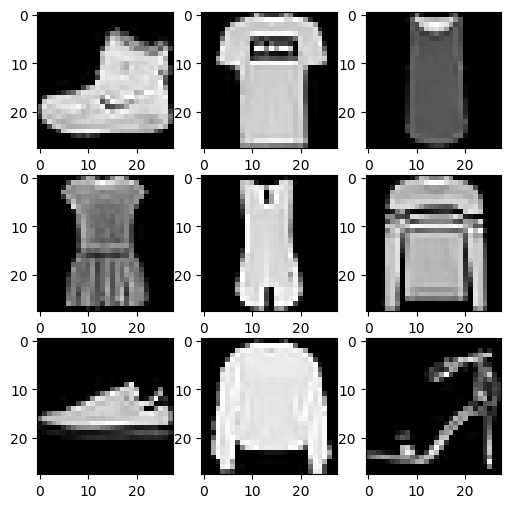

In [2]:
no_class = 9

plt.figure(figsize=(6,6))  
for i in range(no_class):
    plt.subplot(3, 3, i+1)
    plt.imshow(xTrain[i], cmap="gray")  
plt.show()


### Question 2 (10 Marks)

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.

Your code should be flexible such that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.

In [3]:
X = xTrain.reshape(xTrain.shape[0], -1)/255.0
k = 10 #number of classes
Y = onehot(yTrain, k)

#input to the network is a 784 dimensional vector
input_dim = X.shape[1]
print(input_dim)

#number of classes, which is same as the number of neurons in the output layers
print(Y.shape)

num_hl = 3 #number of hidden layers in the network
num_neurons = [128, 64, 32] #number of neurons per hidden layer

def neuron(input, w, b):
    a = np.dot(input, w)+b
    return a

def hiddenlayer(a, activation):
    h = activation(a)
    return h


class forwardPass:
    def __init__(self, input_dim, num_hl, num_neurons, output_dim):
        layers = [input_dim] + num_neurons + [output_dim]
        np.random.seed(42)
        self.weights = []
        self.biases = []
        
        for i in range(len(layers) - 1):
            w = np.random.randn(layers[i], layers[i+1]) * 0.01
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def forward_propagation(self, X):
        activations = [X]
        for i in range(len(self.weights) - 1):
            X = neuron(X, self.weights[i], self.biases[i])
            X = hiddenlayer(X, Activations.sigmoid)
            activations.append(X)
        output = np.dot(X, self.weights[-1]) + self.biases[-1]
        output = softmax(output)
        activations.append(output)
        return activations

nn2 = forwardPass(input_dim, num_hl, num_neurons, k)
num_test_images = int(input(f"number of images to get the probability distribution: "))
probabilities = nn2.forward_propagation(X)
print(probabilities[-1][:num_test_images])





784
(60000, 10)
[[0.09768746 0.09825    0.09604513 0.10102063 0.10062918 0.0991858
  0.09763978 0.10044568 0.10659635 0.10249999]
 [0.09768744 0.09825009 0.09604503 0.10102075 0.10062896 0.09918593
  0.0976397  0.10044572 0.10659659 0.10249979]
 [0.09768748 0.09824992 0.09604507 0.1010207  0.10062903 0.09918586
  0.09763971 0.10044564 0.10659667 0.10249992]
 [0.09768749 0.0982499  0.09604506 0.10102069 0.10062898 0.09918587
  0.09763969 0.10044565 0.10659673 0.10249993]
 [0.09768743 0.09824985 0.09604514 0.10102058 0.1006291  0.09918584
  0.09763976 0.10044559 0.10659673 0.10249998]]


### Question 3 (24 Marks)

Implement the backpropagation algorithm with support for the following optimisation functions 

- sgd
- momentum based gradient descent
- nesterov accelerated gradient descent
- rmsprop
- adam
- nadam

(12 marks for the backpropagation framework and 2 marks for each of the optimisation algorithms above)

We will check the code for implementation and ease of use (e.g., how easy it is to add a new optimisation algorithm such as Eve). Note that the code should be flexible enough to work with different batch sizes.

Epoch 1/10, Loss: 2.3027, Accuracy: 0.1000, Val Loss: 2.3029, Val Accuracy: 0.1003
Epoch 2/10, Loss: 2.3016, Accuracy: 0.1000, Val Loss: 2.3018, Val Accuracy: 0.1003
Epoch 3/10, Loss: 1.2283, Accuracy: 0.5610, Val Loss: 1.2258, Val Accuracy: 0.5628
Epoch 4/10, Loss: 0.5707, Accuracy: 0.7982, Val Loss: 0.5774, Val Accuracy: 0.7940
Epoch 5/10, Loss: 0.4740, Accuracy: 0.8350, Val Loss: 0.4916, Val Accuracy: 0.8265
Epoch 6/10, Loss: 0.4341, Accuracy: 0.8446, Val Loss: 0.4574, Val Accuracy: 0.8333
Epoch 7/10, Loss: 0.3968, Accuracy: 0.8557, Val Loss: 0.4270, Val Accuracy: 0.8485
Epoch 8/10, Loss: 0.3815, Accuracy: 0.8608, Val Loss: 0.4169, Val Accuracy: 0.8497
Epoch 9/10, Loss: 0.3511, Accuracy: 0.8737, Val Loss: 0.3903, Val Accuracy: 0.8595
Epoch 10/10, Loss: 0.3279, Accuracy: 0.8825, Val Loss: 0.3715, Val Accuracy: 0.8677


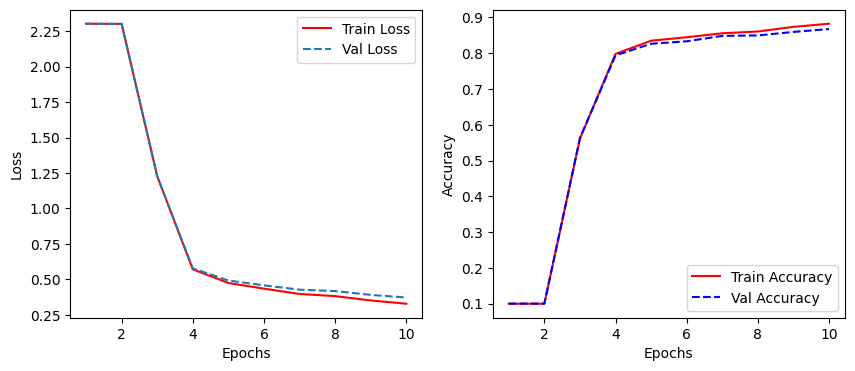

In [4]:
batch_size = 64
epochs = 10  
learning_rate = 0.1 
weight_decay = 0.0005

class Optimisation:
    @staticmethod
    def sgd(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        for i in range(len(weights)):
            weights[i] -= learning_rate * (gradients[i][0] + weight_decay * weights[i])
            biases[i] -= learning_rate * gradients[i][1]

    @staticmethod
    def momentum(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta = params.get('beta', 0.9)
        if 'velocity' not in params:
            params['velocity'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            params['velocity'][i] = (beta * params['velocity'][i][0] + (1 - beta) * gradients[i][0],
                                     beta * params['velocity'][i][1] + (1 - beta) * gradients[i][1])
            weights[i] -= learning_rate * (params['velocity'][i][0] + weight_decay * weights[i])
            biases[i] -= learning_rate * params['velocity'][i][1]

    @staticmethod
    def nesterov(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta = params.get('beta', 0.9)
        if 'velocity' not in params:
            params['velocity'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            prev_velocity = params['velocity'][i]
            params['velocity'][i] = (beta * prev_velocity[0] + learning_rate * gradients[i][0],
                                     beta * prev_velocity[1] + learning_rate * gradients[i][1])
            weights[i] -= beta * prev_velocity[0] + (1 + beta) * (params['velocity'][i][0] + weight_decay * weights[i])
            biases[i] -= beta * prev_velocity[1] + (1 + beta) * params['velocity'][i][1]

    @staticmethod
    def rmsprop(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta = params.get('beta', 0.9)
        epsilon = params.get('epsilon', 1e-8)
        if 'cache' not in params:
            params['cache'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            params['cache'][i] = (beta * params['cache'][i][0] + (1 - beta) * (gradients[i][0] ** 2),
                                  beta * params['cache'][i][1] + (1 - beta) * (gradients[i][1] ** 2))
            weights[i] -= learning_rate * gradients[i][0] / (np.sqrt(params['cache'][i][0]) + epsilon) + weight_decay * weights[i]
            biases[i] -= learning_rate * gradients[i][1] / (np.sqrt(params['cache'][i][1]) + epsilon)

    @staticmethod
    def adam(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta1, beta2 = 0.9, 0.999
        epsilon = 1e-8
        if 'm' not in params:
            params['m'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
            params['v'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            params['m'][i] = (beta1 * params['m'][i][0] + (1 - beta1) * gradients[i][0],
                              beta1 * params['m'][i][1] + (1 - beta1) * gradients[i][1])
            params['v'][i] = (beta2 * params['v'][i][0] + (1 - beta2) * (gradients[i][0] ** 2),
                              beta2 * params['v'][i][1] + (1 - beta2) * (gradients[i][1] ** 2))
            weights[i] -= learning_rate * params['m'][i][0] / (np.sqrt(params['v'][i][0]) + epsilon) + weight_decay * weights[i]
            biases[i] -= learning_rate * params['m'][i][1] / (np.sqrt(params['v'][i][1]) + epsilon)

class FeedForwardNN:
    def __init__(self, input_dim, num_hl, num_neurons, output_dim):
        layers = [input_dim] + num_neurons + [output_dim]
        np.random.seed(42)
        self.weights = []
        self.biases = []
        
        for i in range(len(layers) - 1):
            w = np.random.randn(layers[i], layers[i+1]) * 0.01
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)
    
    def forward_propagation(self, X, activation_function):
        activations = [X]
        for i in range(len(self.weights) - 1):
            X = neuron(X, self.weights[i], self.biases[i])
            X = hiddenlayer(X, activation_function)
            activations.append(X)
        output = neuron(X, self.weights[-1], self.biases[-1])
        output = softmax(output)
        activations.append(output)
        return activations
    
    def backward_propagation(self, X, Y, optimizer, params, activation_function, activation_derivative):
        num_samples = X.shape[0]
        for batch_start in range(0, num_samples, batch_size):
            batch_end = min(batch_start + batch_size, num_samples)
            X_batch = X[batch_start:batch_end]
            Y_batch = Y[batch_start:batch_end]
            
            activations = self.forward_propagation(X_batch, activation_function)
            gradients_w = []
            gradients_b = []
            m = Y_batch.shape[0]
            
            dZ = activations[-1] - Y_batch
            for i in range(len(self.weights) - 1, -1, -1):
                dW = np.dot(activations[i].T, dZ) / m
                dB = np.sum(dZ, axis=0, keepdims=True) / m
                gradients_w.insert(0, dW)
                gradients_b.insert(0, dB)
                
                if i > 0:
                    dA = np.dot(dZ, self.weights[i].T)
                    dZ = dA * activation_derivative(activations[i])
            
            optimizer(self.weights, self.biases, list(zip(gradients_w, gradients_b)), params)
    
    def train(self, X, Y, optimizer, params, activation_function, activation_derivative):
      
        split_index = int(0.9 * X.shape[0])
        X_train, Y_train = X[:split_index], Y[:split_index]
        X_val, Y_val = X[split_index:], Y[split_index:]

        losses, accuracies = [], []
        val_losses, val_accuracies = [], []

        for epoch in range(epochs):
           
            self.backward_propagation(X_train, Y_train, optimizer, params, activation_function, activation_derivative)
            train_activations = self.forward_propagation(X_train, activation_function)
            train_loss = cross_ent_loss(Y_train, train_activations[-1])
            train_accuracy = accuracy_calc(Y_train, train_activations[-1])

            val_activations = self.forward_propagation(X_val, activation_function)
            val_loss = cross_ent_loss(Y_val, val_activations[-1])
            val_accuracy = accuracy_calc(Y_val, val_activations[-1])

            losses.append(train_loss)
            accuracies.append(train_accuracy)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}, "
                f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(range(1, epochs + 1), losses, label='Train Loss', color='red')
        plt.plot(range(1, epochs + 1), val_losses, label='Val Loss', linestyle='dashed')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, epochs + 1), accuracies, label='Train Accuracy', color='red')
        plt.plot(range(1, epochs + 1), val_accuracies, label='Val Accuracy', color='blue', linestyle='dashed')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()


nn = FeedForwardNN(input_dim, num_hl, num_neurons, k)
params = {'learning_rate': learning_rate, 'weight_decay':weight_decay}
nn.train(X, Y, Optimisation.sgd, params, Activations.relu, Activations.relu_derivative)



### Question 4 (10 Marks)

Use the sweep functionality provided by wandb to find the best values for the hyperparameters listed below. Use the standard train/test split of fashion_mnist (use ```(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()```).  Keep 10% of the training data aside as validation data for this hyperparameter search. Here are some suggestions for different values to try for hyperparameters. As you can quickly see that this leads to an exponential number of combinations. You will have to think about strategies to do this hyperparameter search efficiently. Check out the options provided by wandb.sweep and write down what strategy you chose and why.

- number of epochs: 5, 10
- number of hidden layers:  3, 4, 5
- size of every hidden layer:  32, 64, 128
- weight decay (L2 regularisation): 0, 0.0005,  0.5
- learning rate: 1e-3, 1 e-4 
- optimizer:  sgd, momentum, nesterov, rmsprop, adam, nadam
- batch size: 16, 32, 64
- weight initialisation: random, Xavier
- activation functions: sigmoid, tanh, ReLU

wandb will automatically generate the following plots. Paste these plots below using the "Add Panel to Report" feature. Make sure you use meaningful names for each sweep (e.g. hl_3_bs_16_ac_tanh to indicate that there were 3 hidden layers, batch size was 16 and activation function was ReLU) instead of using the default names (whole-sweep, kind-sweep) given by wandb.

In [5]:
import wandb
import numpy as np
import matplotlib.pyplot as plt

batch_size = 64
epochs = 10  
learning_rate = 0.1 
weight_decay = 0.0005

class Optimisation:
    @staticmethod
    def sgd(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        for i in range(len(weights)):
            weights[i] -= learning_rate * (gradients[i][0] + weight_decay * weights[i])
            biases[i] -= learning_rate * gradients[i][1]

    @staticmethod
    def momentum(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta = params.get('beta', 0.9)
        if 'velocity' not in params:
            params['velocity'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            params['velocity'][i] = (beta * params['velocity'][i][0] + (1 - beta) * gradients[i][0],
                                     beta * params['velocity'][i][1] + (1 - beta) * gradients[i][1])
            weights[i] -= learning_rate * (params['velocity'][i][0] + weight_decay * weights[i])
            biases[i] -= learning_rate * params['velocity'][i][1]

    @staticmethod
    def adam(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta1, beta2 = 0.9, 0.999
        epsilon = 1e-8
        if 'm' not in params:
            params['m'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
            params['v'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            params['m'][i] = (beta1 * params['m'][i][0] + (1 - beta1) * gradients[i][0],
                              beta1 * params['m'][i][1] + (1 - beta1) * gradients[i][1])
            params['v'][i] = (beta2 * params['v'][i][0] + (1 - beta2) * (gradients[i][0] ** 2),
                              beta2 * params['v'][i][1] + (1 - beta2) * (gradients[i][1] ** 2))
            weights[i] -= learning_rate * params['m'][i][0] / (np.sqrt(params['v'][i][0]) + epsilon) + weight_decay * weights[i]
            biases[i] -= learning_rate * params['m'][i][1] / (np.sqrt(params['v'][i][1]) + epsilon)

    @staticmethod
    def nesterov(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta = params.get('beta', 0.9)
        if 'velocity' not in params:
            params['velocity'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            prev_velocity = params['velocity'][i]
            params['velocity'][i] = (beta * prev_velocity[0] + learning_rate * gradients[i][0],
                                     beta * prev_velocity[1] + learning_rate * gradients[i][1])
            weights[i] -= beta * prev_velocity[0] + (1 + beta) * (params['velocity'][i][0] + weight_decay * weights[i])
            biases[i] -= beta * prev_velocity[1] + (1 + beta) * params['velocity'][i][1]

    @staticmethod
    def rmsprop(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta = params.get('beta', 0.9)
        epsilon = params.get('epsilon', 1e-8)
        if 'cache' not in params:
            params['cache'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
        for i in range(len(weights)):
            params['cache'][i] = (beta * params['cache'][i][0] + (1 - beta) * (gradients[i][0] ** 2),
                                  beta * params['cache'][i][1] + (1 - beta) * (gradients[i][1] ** 2))
            weights[i] -= learning_rate * gradients[i][0] / (np.sqrt(params['cache'][i][0]) + epsilon) + weight_decay * weights[i]
            biases[i] -= learning_rate * gradients[i][1] / (np.sqrt(params['cache'][i][1]) + epsilon)


    @staticmethod
    def nadam(weights, biases, gradients, params):
        learning_rate = params['learning_rate']
        weight_decay = params['weight_decay']
        beta1, beta2 = 0.9, 0.999
        epsilon = 1e-8
        
        if 'm' not in params:
            params['m'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
            params['v'] = [(np.zeros_like(w), np.zeros_like(b)) for w, b in zip(weights, biases)]
            params['t'] = 0  # Time step
        
        params['t'] += 1
        mu_t = beta1 * (1 - 0.5 * (0.96 ** (params['t'] / 250)))

        for i in range(len(weights)):
            params['m'][i] = (beta1 * params['m'][i][0] + (1 - beta1) * gradients[i][0],
                            beta1 * params['m'][i][1] + (1 - beta1) * gradients[i][1])
            params['v'][i] = (beta2 * params['v'][i][0] + (1 - beta2) * (gradients[i][0] ** 2),
                            beta2 * params['v'][i][1] + (1 - beta2) * (gradients[i][1] ** 2))

            m_hat = (mu_t * params['m'][i][0] + (1 - mu_t) * gradients[i][0]) / (1 - beta1 ** params['t'])
            v_hat = params['v'][i][0] / (1 - beta2 ** params['t'])

            weights[i] -= learning_rate * m_hat / (np.sqrt(v_hat) + epsilon) + weight_decay * weights[i]

            m_hat_b = (mu_t * params['m'][i][1] + (1 - mu_t) * gradients[i][1]) / (1 - beta1 ** params['t'])
            v_hat_b = params['v'][i][1] / (1 - beta2 ** params['t'])

            biases[i] -= learning_rate * m_hat_b / (np.sqrt(v_hat_b) + epsilon)

class FeedForwardNN:
    def __init__(self, input_dim, num_hl, num_neurons, output_dim, params):
        layers = [input_dim] + num_neurons + [output_dim]
        np.random.seed(42)

        self.weights = []
        self.biases = []

        for i in range(len(layers) - 1):
            if params['init_method'] == 'random': 
                w = np.random.randn(layers[i], layers[i+1]) * 0.01
            elif params['init_method'] == 'xavier': 
                w = np.random.randn(layers[i], layers[i+1]) * np.sqrt(1 / layers[i])
            b = np.zeros((1, layers[i+1]))
            self.weights.append(w)
            self.biases.append(b)

    def forward_propagation(self, X, activation_function):
        activations = [X]
        for i in range(len(self.weights) - 1):
            X = hiddenlayer(neuron(X, self.weights[i], self.biases[i]), activation_function)
            activations.append(X)
        output = softmax(neuron(X, self.weights[-1], self.biases[-1]))
        activations.append(output)
        return activations
    
    def backward_propagation(self, X, Y, optimizer, params, activation_function, activation_derivative):
        batch_size = params['batch_size']
        num_samples = X.shape[0]
        for batch_start in range(0, num_samples, batch_size):
            batch_end = min(batch_start + batch_size, num_samples)
            X_batch, Y_batch = X[batch_start:batch_end], Y[batch_start:batch_end]
            activations = self.forward_propagation(X_batch, activation_function)
            gradients_w, gradients_b = [], []
            dZ = activations[-1] - Y_batch
            for i in range(len(self.weights) - 1, -1, -1):
                dW = np.dot(activations[i].T, dZ) / batch_size
                dB = np.sum(dZ, axis=0, keepdims=True) / batch_size
                gradients_w.insert(0, dW)
                gradients_b.insert(0, dB)
                if i > 0:
                    dA = np.dot(dZ, self.weights[i].T)
                    dZ = dA * activation_derivative(activations[i])
            optimizer(self.weights, self.biases, list(zip(gradients_w, gradients_b)), params)
    
    def train(self, X, Y, optimizer, params, activation_function, activation_derivative):
        
        X_train, Y_train, X_val, Y_val = X[:int(0.9 * X.shape[0])], Y[:int(0.9 * X.shape[0])], X[int(0.9 * X.shape[0]):], Y[int(0.9 * X.shape[0]):]
        for epoch in range(params['epochs']):
            self.backward_propagation(X_train, Y_train, optimizer, params, activation_function, activation_derivative)
            wandb.log({"train_loss": cross_ent_loss(Y_train, self.forward_propagation(X_train, activation_function)[-1]),
                       "train_accuracy": accuracy_calc(Y_train, self.forward_propagation(X_train, activation_function)[-1]),
                       "val_loss": cross_ent_loss(Y_val, self.forward_propagation(X_val, activation_function)[-1]),
                       "val_accuracy": accuracy_calc(Y_val, self.forward_propagation(X_val, activation_function)[-1]),
                       "epoch": epoch})
            
    def train_se(self, X, Y, optimizer, params, activation_function, activation_derivative, best_val_acc_ce):
        """Train using Squared Error Loss."""
        X_train, Y_train, X_val, Y_val = X[:int(0.9 * X.shape[0])], Y[:int(0.9 * X.shape[0])], X[int(0.9 * X.shape[0]):], Y[int(0.9 * X.shape[0]):]
        for epoch in range(params['epochs']):
            self.backward_propagation(X_train, Y_train, optimizer, params, activation_function, activation_derivative)
            output_train = self.forward_propagation(X_train, activation_function)[-1]
            output_val = self.forward_propagation(X_val, activation_function)[-1]

            loss_se_train = np.mean((output_train - Y_train) ** 2)
            loss_se_val = np.mean((output_val - Y_val) ** 2)
            train_acc = np.mean(np.argmax(output_train, axis=1) == np.argmax(Y_train, axis=1))
            val_acc = np.mean(np.argmax(output_val, axis=1) == np.argmax(Y_val, axis=1))

            

    def test(self, Xt, Yt, activation):
        pred = self.forward_propagation(Xt, activation)[-1]
        y_pred = np.argmax(pred, axis=1)
        return y_pred


sweep_config = {
    'method': 'bayes',
    'metric': {'name': 'val_accuracy', 'goal': 'maximize'},
    'parameters': {
        'epochs': {'values': [5, 10]},
        'n_hidden': {'values': [3, 4, 5]},
        'n_hidden_units': {'values': [32, 64, 128]},
        'weight_decay': {'values': [0, 0.0005, 0.5]},
        'lr': {'values': [1e-3, 1e-4]},
        'optim_algo': {'values': ['sgd', 'momentum', 'adam', 'nadam', 'nesterov', 'rmsprop']},
        'batch_size': {'values': [16, 32, 64]},
        'weight_init': {'values': ['random', 'xavier']},
        'activation': {'values': ['relu', 'sigmoid', 'tanh']},
        
    }
}


sweep_id = wandb.sweep(sweep_config, project='Assignment 1')

def train_model():
    wandb.init()
    config = wandb.config
    wandb.run.name = 'hl_'+str(config.n_hidden)+'_bs_'+str(config.batch_size)+'_act_'+str(config.activation)
    model = FeedForwardNN(784, config.n_hidden, [config.n_hidden_units] * config.n_hidden, 10, {'init_method' : config.weight_init})
    model.train(xTrain.reshape(xTrain.shape[0], -1), onehot(yTrain, 10), getattr(Optimisation(), config.optim_algo),
                {'learning_rate': config.lr, 'weight_decay': config.weight_decay, 'epochs': config.epochs, 'batch_size':config.batch_size},
                getattr(Activations, config.activation), getattr(Activations, f'{config.activation}_derivative'))
    
    

wandb.agent(sweep_id, train_model, count=5)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: d4q8w22j
Sweep URL: https://wandb.ai/da24s008-indian-institute-of-technology-madras/Assignment%201/sweeps/d4q8w22j


wandb: Agent Starting Run: 4amykakn with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: momentum
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random
wandb: Currently logged in as: da24s008 (da24s008-indian-institute-of-technology-madras) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,█▁▁▁▁▁▁▁▁▁
train_loss,█▇▇▆▅▅▄▃▂▁
val_accuracy,█▁▁▁▁▁▁▁▁▁
val_loss,▁▃▄▆▇▇███▇
epoch,9
train_accuracy,0.10083
train_loss,2.3025
val_accuracy,0.0925
val_loss,2.30261


wandb: Agent Starting Run: 1k208pfu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 64
wandb: 	epochs: 5
wandb: 	lr: 0.001
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: adam
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


/tmp/ipykernel_1609663/4291229462.py:12: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


epoch,▁▃▅▆█
train_accuracy,▁▃▅█▇
train_loss,█▄▃▁▁
val_accuracy,▁▄▆█▇
val_loss,█▄▃▂▁
epoch,4
train_accuracy,0.54598
train_loss,1.13495
val_accuracy,0.55467
val_loss,1.13067


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 8g3qtw21 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	lr: 0.0001
wandb: 	n_hidden: 3
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: rmsprop
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: random


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▆█▅▆▄▄▄▄▄
train_loss,█▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅█▅▅▂▃▃▄▄
val_loss,█▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.20546
train_loss,1.77115
val_accuracy,0.19717
val_loss,1.77367


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: jibdym31 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	lr: 0.001
wandb: 	n_hidden: 5
wandb: 	n_hidden_units: 32
wandb: 	optim_algo: nesterov
wandb: 	weight_decay: 0.0005
wandb: 	weight_init: xavier


epoch,▁▂▃▃▄▅▆▆▇█
train_accuracy,▁▁▁▁▁▁▁▁▁▁
train_loss,▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁
epoch,9
train_accuracy,0.09996
train_loss,2.30274
val_accuracy,0.10033
val_loss,2.30309


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xcn21aw8 with config:
wandb: 	activation: relu
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	lr: 0.001
wandb: 	n_hidden: 4
wandb: 	n_hidden_units: 64
wandb: 	optim_algo: momentum
wandb: 	weight_decay: 0.5
wandb: 	weight_init: random


epoch,▁▃▅▆█
train_accuracy,▁▁▁▁▁
train_loss,█▅▂▁▁
val_accuracy,▁▁▁▁▁
val_loss,▁▄▆▇█
epoch,4
train_accuracy,0.10083
train_loss,2.30258
val_accuracy,0.0925
val_loss,2.30273


### Question 5 (5 marks)

We would like to see the best accuracy on the validation set across all the models that you train.

wandb automatically generates this plot which summarises the test accuracy of all the models that you tested. Please paste this plot below using the "Add Panel to Report" feature

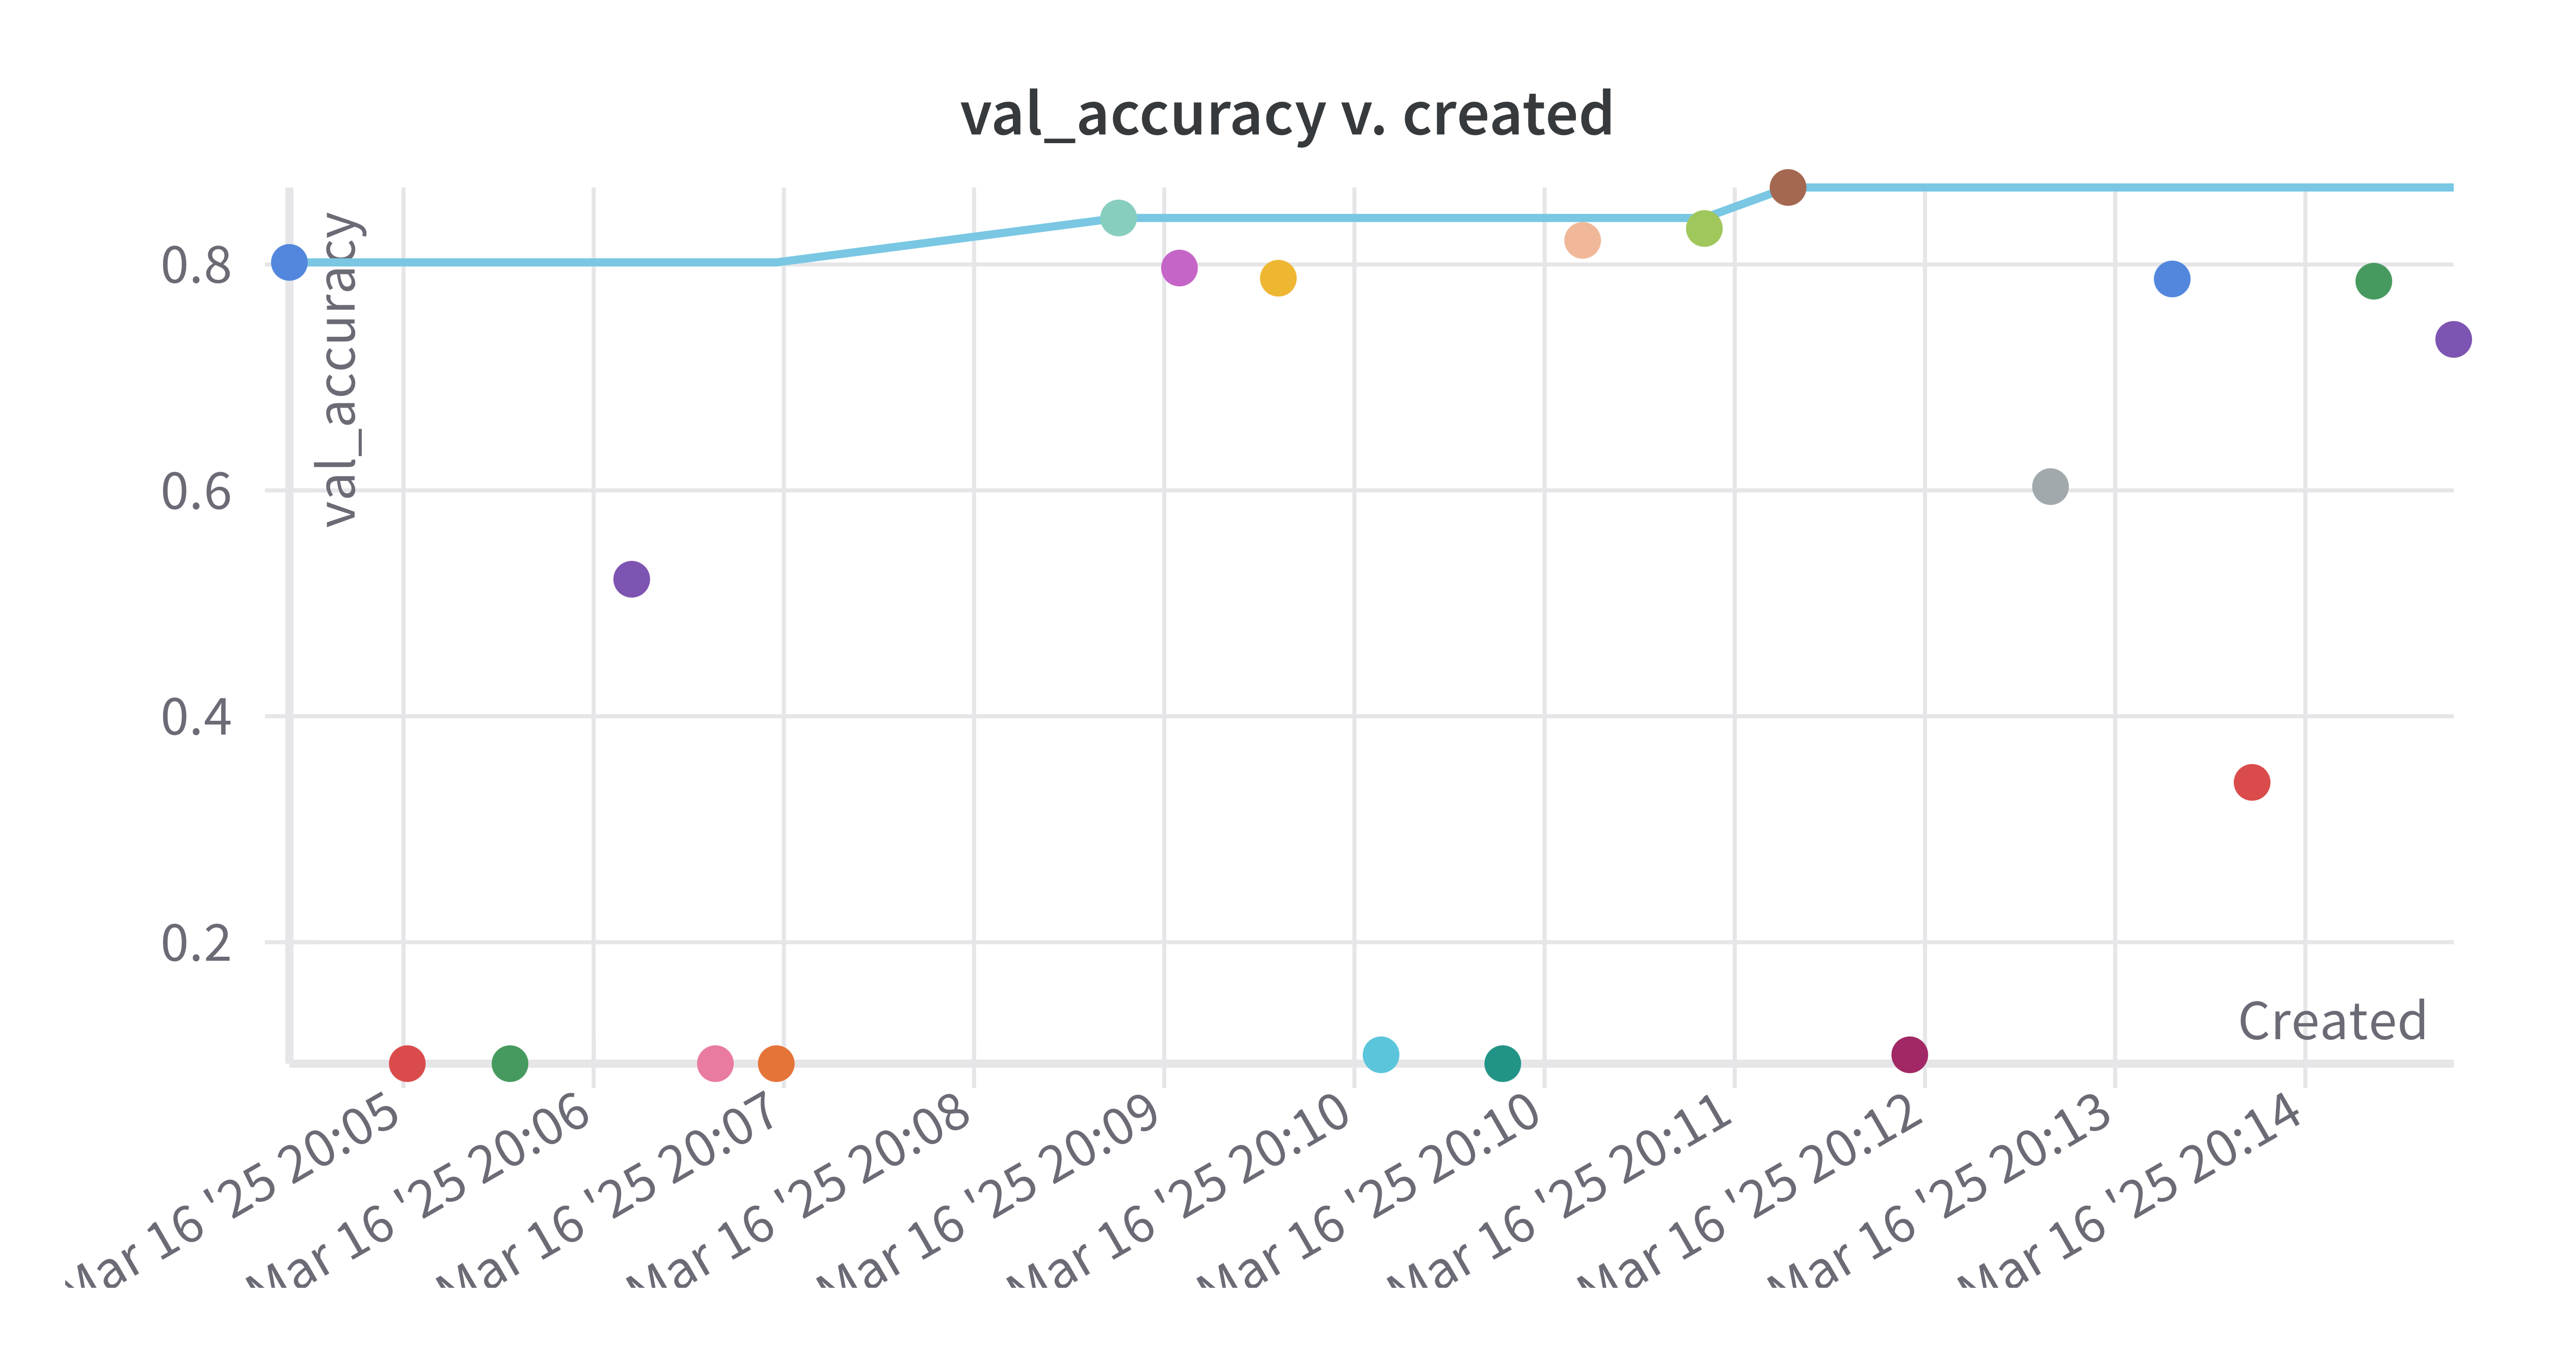

### Question 6 (20 Marks)

Based on the different experiments that you have run we want you to make some inferences about which configurations worked and which did not.

Here again, wandb automatically generates a "Parallel co-ordinates plot" and a "correlation summary" as shown below. Learn about a "Parallel co-ordinates plot" and how to read it.

By looking at the plots that you get, write down some interesting observations (simple bullet points but should be insightful). You can also refer to the plot in Question 5 while writing these insights. For example, in the above sample plot there are many configurations which give less than 65% accuracy. I would like to zoom into those and see what is happening.

I would also like to see a recommendation for what configuration to use to get close to 95% accuracy.

### Question 7 (10 Marks)

For the best model identified above, report the accuracy on the test set of fashion_mnist and plot the confusion matrix as shown below. More marks for creativity (less marks for producing the plot shown below as it is)

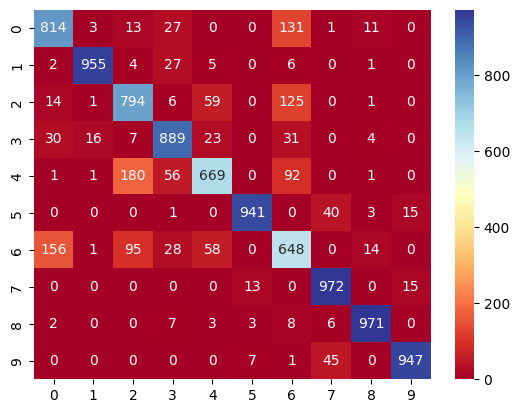

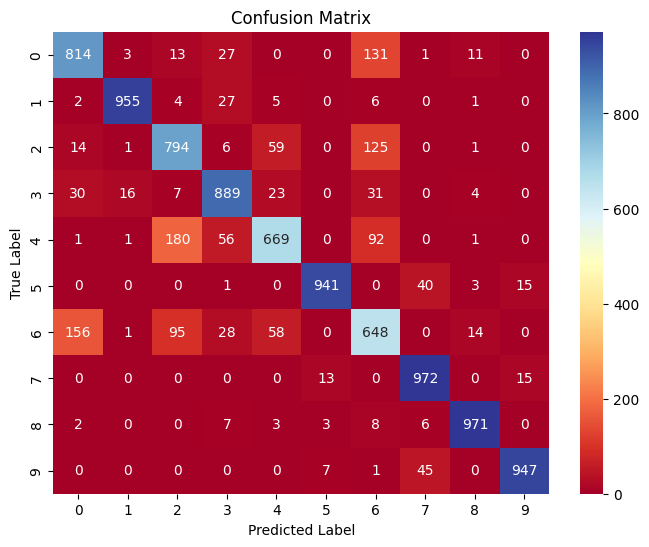

In [6]:
import seaborn as sns


def confustion_mat(y_true, y_pred):
    classes = np.unique(y_true)
    no_classes = len(classes)
    conf = np.zeros((no_classes, no_classes), dtype = int)

    for i in range(no_classes):
        for j in range(no_classes):
            conf[i, j] = np.sum((y_true == classes[i]) & (y_pred == classes[j]))
    return conf

api = wandb.Api()
best_run = api.runs("Assignment 1")
best_run = sorted(best_run, key=lambda x: x.summary.get("val_accuracy", 0), reverse=True)[0] 

best_config = best_run.config
best_model = FeedForwardNN(
    784, best_config['n_hidden'], [best_config['n_hidden_units']] * best_config['n_hidden'], 10,
    {'init_method': best_config['weight_init']}
)
wandb.init()
best_model.train(
    xTrain.reshape(xTrain.shape[0], -1), onehot(yTrain, 10),
    getattr(Optimisation(), best_config['optim_algo']),
    {'learning_rate': best_config['lr'], 'weight_decay': best_config['weight_decay'], 'epochs': best_config['epochs'], 'batch_size': best_config['batch_size']},
    getattr(Activations, best_config['activation']),
    getattr(Activations, f'{best_config["activation"]}_derivative')
)
y_pred = best_model.test(xTest.reshape(xTest.shape[0], -1), onehot(yTest, 10), getattr(Activations, best_config['activation']))

conf_mat = confustion_mat(yTest, y_pred)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="RdYlBu", xticklabels=range(10), yticklabels=range(10))
plt.figure(figsize=(8, 6))
fig1 = sns.heatmap(conf_mat, annot=True, fmt="d", cmap="RdYlBu", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
wandb.log({"Confusion Matrix": wandb.Image(plt)})



### Question 8

In all the models above you would have used cross entropy loss. Now compare the cross entropy loss with the squared error loss. I would again like to see some automatically generated plots or your own plots to convince me whether one is better than the other.

In [7]:

def squared_error_loss(y_true, y_pred):
    return np.mean(np.sum((y_true - y_pred) ** 2, axis=1))

def train_se(self, X, Y, optimizer, params, activation_function, activation_derivative, best_val_acc_ce):
    X_train, Y_train = X[:int(0.9 * X.shape[0])], Y[:int(0.9 * X.shape[0])]
    X_val, Y_val = X[int(0.9 * X.shape[0]):], Y[int(0.9 * X.shape[0]):]

    train_losses_se, train_accuracies_se = [], []
    val_losses_se, val_accuracies_se = [], []

    for epoch in range(params['epochs']):
        self.backward_propagation(X_train, Y_train, optimizer, params, activation_function, activation_derivative)

        output_train = self.forward_propagation(X_train, activation_function)[-1]
        output_val = self.forward_propagation(X_val, activation_function)[-1]

        loss_train_se = squared_error_loss(Y_train, output_train)
        loss_val_se = squared_error_loss(Y_val, output_val)

        train_acc = np.mean(np.argmax(output_train, axis=1) == np.argmax(Y_train, axis=1))
        val_acc = np.mean(np.argmax(output_val, axis=1) == np.argmax(Y_val, axis=1))

        train_losses_se.append(loss_train_se)
        train_accuracies_se.append(train_acc)
        val_losses_se.append(loss_val_se)
        val_accuracies_se.append(val_acc)

        wandb.log({
            "train_loss_se": loss_train_se,
            "train_accuracy_se": train_acc,
            "val_loss_se": loss_val_se,
            "val_accuracy_se": val_acc,
            "best_val_accuracy_ce": best_val_acc_ce,
            "epoch": epoch
        })
    
    return train_losses_se, train_accuracies_se, val_losses_se, val_accuracies_se

# Load Best CE-trained Model & Train with SE
best_val_acc_ce = best_run.summary.get("val_accuracy", 0)

train_losses_se, train_accuracies_se, val_losses_se, val_accuracies_se = best_model.train_se(
    xTrain.reshape(xTrain.shape[0], -1), onehot(yTrain, 10),
    getattr(Optimisation(), best_config['optim_algo']),
    {
        'learning_rate': best_config['lr'],
        'weight_decay': best_config['weight_decay'],
        'epochs': best_config['epochs'],
        'batch_size': best_config['batch_size']
    },
    getattr(Activations, best_config['activation']),
    getattr(Activations, f'{best_config["activation"]}_derivative'),
    best_val_acc_ce
)

# Extract stored CE metrics from the best run
api = wandb.Api()
ce_run = api.run(best_run.path)
train_losses_ce = ce_run.history(keys=["train_loss"])
train_accuracies_ce = ce_run.history(keys=["train_accuracy"])
val_losses_ce = ce_run.history(keys=["val_loss"])
val_accuracies_ce = ce_run.history(keys=["val_accuracy"])

epochs = range(len(train_losses_se))

# Plot Loss & Accuracy Comparison
plt.figure(figsize=(12, 6))

# Train Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses_ce, label="CE Loss", color='b')
plt.plot(epochs, train_losses_se, label="SE Loss", color='r')
plt.xlabel("Epochs")
plt.ylabel("Train Loss")
plt.title("Training Loss: CE vs SE")
plt.legend()

# Train Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies_ce, label="CE Accuracy", color='b')
plt.plot(epochs, train_accuracies_se, label="SE Accuracy", color='r')
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")
plt.title("Training Accuracy: CE vs SE")
plt.legend()

# Validation Loss
plt.subplot(2, 2, 3)
plt.plot(epochs, val_losses_ce, label="CE Loss", color='b')
plt.plot(epochs, val_losses_se, label="SE Loss", color='r')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")
plt.title("Validation Loss: CE vs SE")
plt.legend()

# Validation Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, val_accuracies_ce, label="CE Accuracy", color='b')
plt.plot(epochs, val_accuracies_se, label="SE Accuracy", color='r')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy: CE vs SE")
plt.legend()

plt.tight_layout()
wandb.log({"CE vs SE Comparison": wandb.Image(plt)})
plt.show()


TypeError: cannot unpack non-iterable NoneType object